In [34]:
import pandas as pd

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import re

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from kmodes.kprototypes import KPrototypes
from sklearn.metrics import silhouette_score
import gower

from scipy import stats
from statsmodels.stats.proportion import proportions_ztest

## Кластеризация

In [2]:
# Загружаем полный обработанный датафрейм
df = pd.read_csv('full_data_new.csv')
df.head()

,id,product,colour,cost,product_sex,base_sale,dt,name_product,category_product,brand,gender,age,education,city,country,personal_coef
0,0,"велосипед горный женский stern mira 20 26""",в нескольких цветах,13599,0,1,7,велосипед,спортинвентарь,stern,0,36,среднее,1201,32,0.5072
1,0,стол outventure,зеленый,1499,2,0,37,стол,отдых/туризм,outventure,0,36,среднее,1201,32,0.5072
2,0,набор outventure стол 4 стула,коричневый,4799,2,0,37,набор,отдых/туризм,outventure,0,36,среднее,1201,32,0.5072
3,3,бутсы мужские gsd astro,белый,1599,1,0,13,бутсы,обувь,другое,1,31,среднее,1134,32,0.4304
4,3,мяч футбольный puma teamfinal 212 fifa quality...,мультицвет,7199,2,0,27,мяч,спортинвентарь,puma,1,31,среднее,1134,32,0.4304


In [3]:
# Убираем ненужные столбцы
df_claster = df.drop(['id', 'product', 'dt', 'city', 'name_product', 'country', 'brand', 'colour', 'product_sex', 'education'], axis = 1)

In [5]:
# Берем часть выборки
df_sample = df_claster.sample(n=30_000, random_state=42).copy()

# Разделяем переменные на числовые и категориальные
categorical = ['category_product']
number = ['cost', 'base_sale', 'gender', 'age', 'personal_coef']

# Стандартизируем числовые признаки
sc = StandardScaler()
df_claster_std = df_sample.copy()
df_claster_std[number] = sc.fit_transform(df_sample[number])

# Берем индекс для категориальных переменных
categorical_index = [df_claster_std.columns.get_loc(col) for col in categorical]

# Создаем отдельный датафрейм для TSNE
df_for_tsne = df_claster_std.copy()

# Кодируем категориальные признаки для TSNE
for col in categorical:
    le = LabelEncoder()
    df_for_tsne[col] = le.fit_transform(df_for_tsne[col])
    
    
tsne = TSNE(n_components=2)
df_tsne = tsne.fit_transform(df_for_tsne)

C:\Users\ST\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\ST\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [6]:
# считаем Gower distance для подсчета силуэта (для KPrototypes)
gower_dist = gower.gower_matrix(df_claster_std)

In [7]:
# Строим графики, для определения кластеров по методу локтя и методу силуэта
kp = KPrototypes(n_clusters=2, init='Cao', random_state=42).fit(df_claster_std, categorical=categorical_index)


inertia = []
silhouette = []
N = 10
for k in range(2, N):
    kp = KPrototypes(n_clusters=k, random_state=42)
    preds = kp.fit_predict(df_claster_std, categorical=categorical_index)
    inertia.append(kp.cost_)
    silhouette.append(silhouette_score(df_for_tsne, preds))

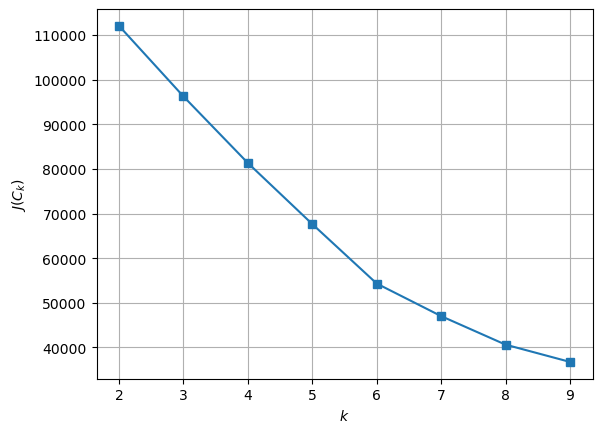

In [8]:
plt.plot(range(2, N), inertia, marker='s');
plt.xlabel('$k$')
plt.grid()
plt.ylabel('$J(C_k)$');

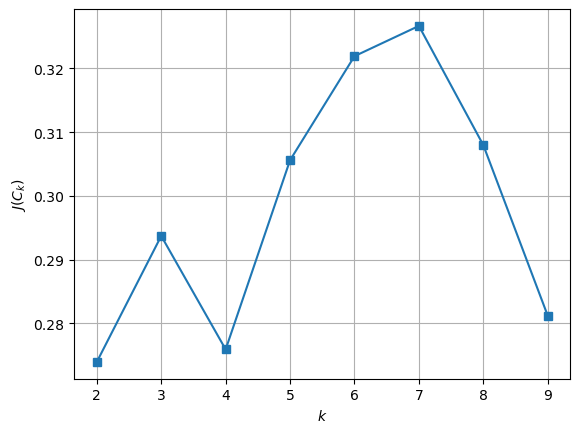

In [9]:
plt.plot(range(2, N), silhouette, marker='s');
plt.xlabel('$k$')
plt.grid()
plt.ylabel('$J(C_k)$');

Количество кластеров равно 7

Silhouette KPrototypes: 0.435062


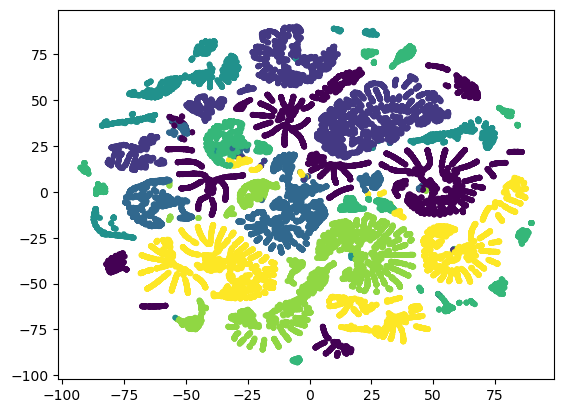

In [10]:
kp7 = KPrototypes(n_clusters=7, init='Cao', random_state=42, gamma = 6.1).fit(df_claster_std, categorical=categorical_index)
plt.scatter(df_tsne[:, 0], df_tsne[:, 1], s=10, c=kp7.labels_)
print("Silhouette KPrototypes:", silhouette_score(gower_dist, kp7.labels_, metric='precomputed'))

In [11]:
df_sample['cluster'] = kp7.labels_

# Средние значения числовых признаков
print(df_sample.groupby('cluster')[number].mean().round(2))

# Модальные значения категориальных признаков
for col in categorical:
    print(f"\n{col}:\n", df_sample.groupby('cluster')[col].agg(lambda x: x.mode()[0]))

             cost  base_sale  gender    age  personal_coef
cluster                                                   
0         2819.98       0.52    0.00  41.52           0.51
1         7044.72       0.36    1.00  38.53           0.44
2        14704.27       0.12    0.67  37.72           0.46
3         2181.93       0.26    0.58  38.92           0.47
4         4639.50       0.28    0.81  24.05           0.34
5         4876.66       0.35    0.00  40.71           0.51
6         3517.96       0.41    1.00  39.62           0.44

category_product:
 cluster
0                   одежда
1                    обувь
2           спортинвентарь
3    аксессуары/уход/карты
4             отдых/туризм
5                    обувь
6                   одежда
Name: category_product, dtype: object


In [12]:
### ВИЗУАЛИЗАЦИИ РАСПРЕДЕЛЕНИЙ ПО КЛАСТЕРАМ

<Figure size 1000x1200 with 0 Axes>

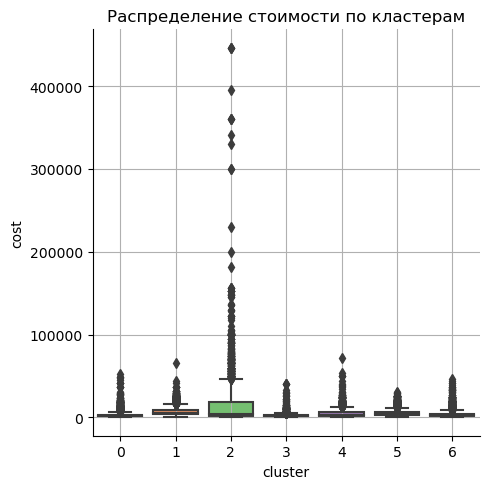

In [13]:
# Cost
plt.figure(figsize=(10, 12)) 
sns.catplot(kind='box', data=df_sample, y='cost', x='cluster', palette="muted", sharey=False)
plt.title('Распределение стоимости по кластерам')
plt.tight_layout()
plt.gcf().patch.set_alpha(0)
plt.grid(True)
plt.show()

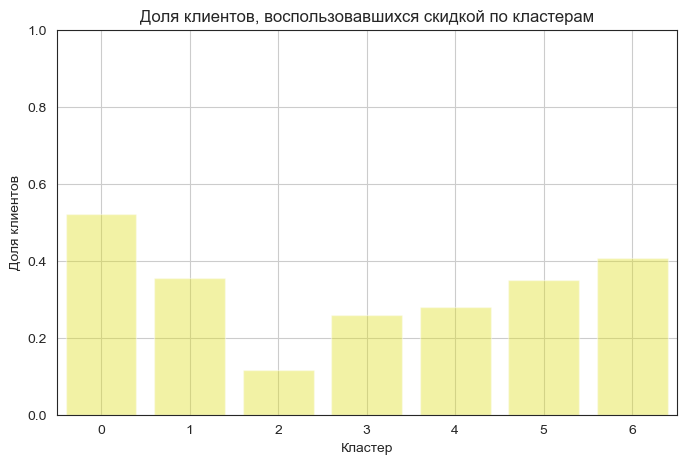

In [16]:
# Информативнее показать долю клиентов, воспользовавшихся скидкой
tub_sale_rate = (df_sample.groupby("cluster")["base_sale"].mean().reset_index().rename(columns={"base_sale": "sale_rate"}))

plt.figure(figsize=(8, 5))
sns.barplot(data=tub_sale_rate, x="cluster", y="sale_rate", color='yellow', alpha=0.4)
sns.set_style("white")
plt.grid(True)
plt.title("Доля клиентов, воспользовавшихся скидкой по кластерам")
plt.ylabel("Доля клиентов")
plt.xlabel("Кластер")
plt.ylim(0, 1)
plt.show()

<Figure size 800x500 with 0 Axes>

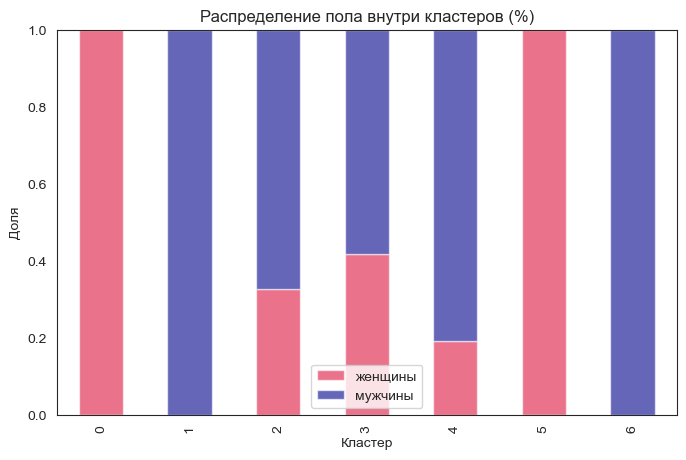

In [19]:
# Строим таблицу частот для каждого кластера
ct = pd.crosstab(df_sample["cluster"], df_sample["gender"], normalize="index")

plt.figure(figsize=(8, 5))
ct.plot(kind="bar", stacked=True, figsize=(8, 5), alpha=0.6, color=["crimson", "#00008B"])

plt.title("Распределение пола внутри кластеров (%)")
plt.grid(False)
plt.ylabel("Доля")
plt.xlabel("Кластер")
plt.legend(["женщины", "мужчины"])
plt.ylim(0, 1)
plt.gcf().patch.set_alpha(0)

plt.show()

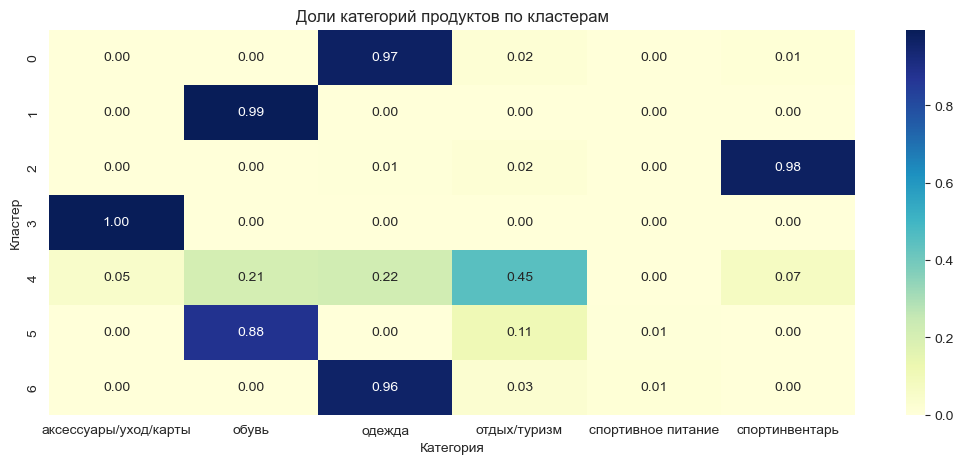

In [21]:
# Категории продуктов по кластерам (доли)
pivot = (df_sample.groupby(['cluster', 'category_product']).size().groupby(level=0).apply(lambda x: x / x.sum()).unstack().fillna(0))

plt.figure(figsize=(13, 5))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Доли категорий продуктов по кластерам")
plt.xlabel("Категория")

plt.ylabel("Кластер")
plt.show()

<Figure size 1000x1200 with 0 Axes>

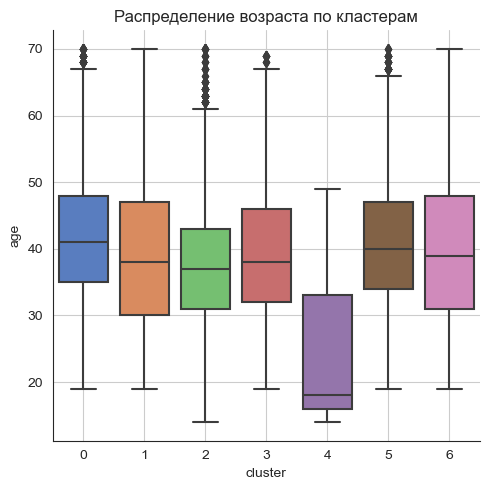

In [22]:
# Age
plt.figure(figsize=(10, 12)) 

sns.catplot(kind='box', data=df_sample, y='age', x='cluster', palette="muted", sharey=False)
plt.title('Распределение возраста по кластерам')
plt.tight_layout()
plt.gcf().patch.set_alpha(0)
plt.grid(True)
plt.show()

<Figure size 1000x1200 with 0 Axes>

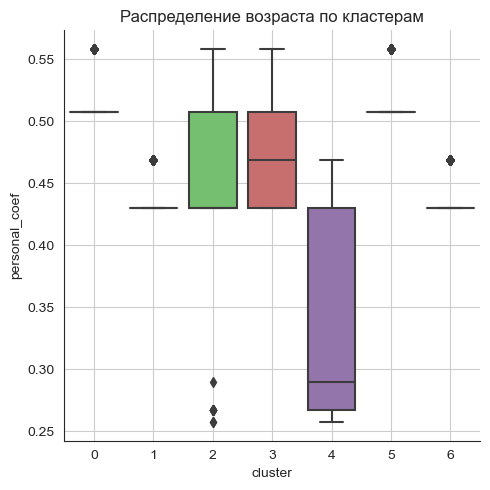

In [23]:
# Age
plt.figure(figsize=(10, 12)) 

sns.catplot(kind='box', data=df_sample, y='personal_coef', x='cluster', palette="muted", sharey=False)
plt.title('Распределение возраста по кластерам')
plt.tight_layout()
plt.gcf().patch.set_alpha(0)
plt.grid(True)
plt.show()

Описание кластеров: \
0 - женская одежда со скидками; \
1 - обувь с высоким среднем чеком для мужчин среднего возраста, реагирующих на скидки, но не сильно; \
2 - дорогие спортивные товары для мужчин и женщин, не реагирующих на скидки (премиальные клиенты); \
3 - товары с низким средним чеком из категории аксессуары/уход для мужчин и женщин, покупаемые без скидок; \
4 - товары для активного отдыха и туризма, для молодежи, преимущественно для мужчин, не очень интересующихся скидками; \
5 - обувь для женщин средней стоимости, скидки важны, но не критично; \
6 - мужская одежда средней стоимости, со скидками. 

Рекомендации: \
0 - всевозможные скидочные кампании, персональные подборки из категории одежда, акции для увеличения количества товара в чеке (покупаешь 3 вещи - получаешь скидку); \
1 - сезонные предложения на обувь, скидка на вторую пару обуви, персональные подборки; \
2 - персональные предложения и пакеты, как для премиальных клиентов, персональная подборка товаров, не предлагать скидок так как они не нужны; \
3 - предлагать покупать сопутствующий товар, предлагать дополнить корзину еще каким-то продуктом, предлагать товар по более дорогой цене или улучшенной версии, тем самым повышая средний чек; \
4 - комплекты и сеты для активного отдыха, подборки товаров для путешествий, делать рекомендации на основе интересов; \
5 - сезонные предложения на обувь, скидка на вторую пару, подборки «тренд сезона»; \
6 - увеличивать средний чек, путем предложения акций 2+1, акции «собери себе образ», распродажи.



## A/B - тестирование

In [24]:
# Условия первой кампании (с 5 по  16 день)
df1 = df[(df['dt'] >= 5)&((df['dt'] <= 16))]
df1.shape

(224428, 16)

In [28]:
# Загружаем файлы
with open ('ids_first_company_positive.txt', 'r', encoding='utf-8') as f:
    text = f.read()
    
ids = re.findall(r'\d+', text)
positive = pd.DataFrame({'id': [int(x) for x in ids]})


with open ('ids_first_company_negative.txt', 'r', encoding='utf-8') as f:
    text = f.read()
    
ids = re.findall(r'\d+', text)
negative = pd.DataFrame({'id': [int(x) for x in ids]})

In [29]:
# Убираем дубликаты
positive = positive.drop_duplicates(subset = 'id')
negative = negative.drop_duplicates(subset = 'id')

# Убираем id которые попали и в positive, и в negative
duplicates = set(positive["id"]) & set(negative["id"])
positive = positive[~positive['id'].isin(duplicates)]
negative = negative[~negative['id'].isin(duplicates)]

In [30]:
# Тестовый и контрольный датафрейм
df_test = df1.merge(positive, on = 'id')
df_control = df1.merge(negative, on = 'id')

In [31]:
# Формируем общий датафрей для А/B тестирования
df_test["group"] = "test"
df_control["group"] = "control"
df_ab = pd.concat([df_test, df_control], ignore_index=True)

#### Средний чек

Так как отсутствует идентификатор одного заказа можно предположить, что один день = одному чеку, но тут тоже может быть вариант, что человек совершил в один день несколько покупок, например утром и вечером. Поэтому два варианта расчета.

Средний чек в каждой группе 
      group     avg_check
0  control  10071.824697
1     test  10590.995560


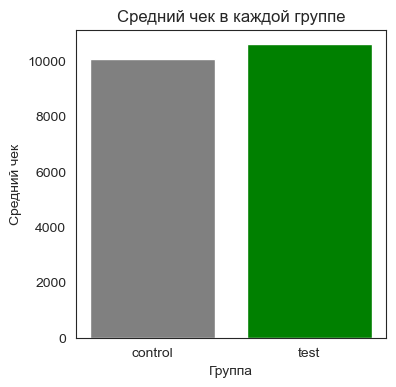

In [32]:
# Если считать, что один чек в один день. 
checks_by_day = df_ab.groupby(['id', 'group', 'dt'])['cost'].sum().reset_index()
avg_check_day = checks_by_day.groupby('group')['cost'].mean().reset_index()
avg_check_day = avg_check_day.rename(columns={'cost':'avg_check'})

print('Средний чек в каждой группе \n', avg_check_day)

plt.figure(figsize = (4, 4))
plt.bar(avg_check_day['group'], avg_check_day['avg_check'], color=['gray', 'green'])
plt.title('Средний чек в каждой группе')
plt.ylabel('Средний чек')
plt.xlabel('Группа')
plt.show()

In [35]:
check_control = checks_by_day.loc[checks_by_day['group'] == 'control', 'cost']
check_test = checks_by_day.loc[checks_by_day['group'] == 'test', 'cost']

print(stats.shapiro(check_control))
print(stats.shapiro(check_test))

ShapiroResult(statistic=0.5178191661834717, pvalue=0.0)
ShapiroResult(statistic=0.5639805793762207, pvalue=0.0)


C:\Users\ST\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Выборка большая, не нужно делать тест Шапиро-Уилка. В любом случае он показывает что распределение ненормальное. \
Но посмотри на графики

<AxesSubplot:xlabel='cost', ylabel='Count'>

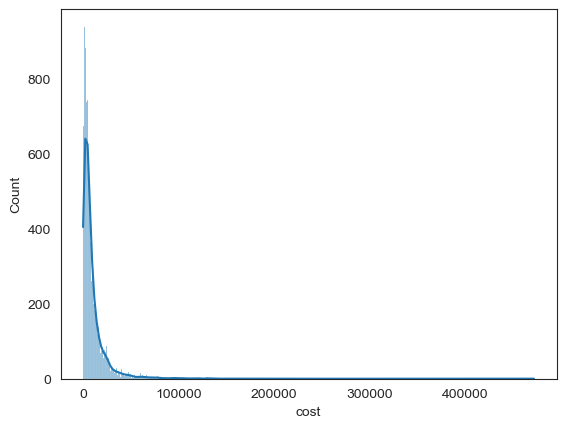

In [36]:
sns.histplot(check_control, kde=True)

<AxesSubplot:xlabel='cost', ylabel='Count'>

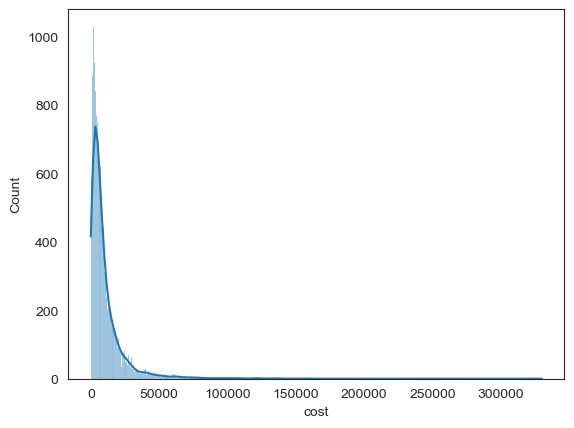

In [37]:
sns.histplot(check_test, kde=True)

Ненормальное распределение, используем тест Манна-Утни

In [38]:
stats.mannwhitneyu(check_control, check_test)

MannwhitneyuResult(statistic=64169910.5, pvalue=2.346330721090678e-10)

Разница в среднем чеке статистически значима

#### Выручка

Выручка в каждой группе 
      group    revenue
0  control  109621740
1     test  131190662


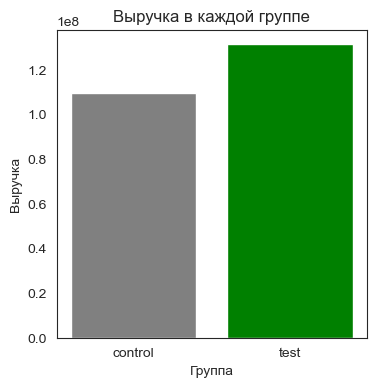

In [39]:
# Выручка
revenue = df_ab.groupby('group', as_index = False)['cost'].sum()
revenue = revenue.rename(columns = {'cost': 'revenue'})
print('Выручка в каждой группе \n', revenue)

plt.figure(figsize = (4, 4))
plt.bar(revenue['group'], revenue['revenue'], color=['gray', 'green'])
plt.title('Выручка в каждой группе')
plt.ylabel('Выручка')
plt.xlabel('Группа')
plt.show()

Выручка в тестовой группе выше. \
Но по общей выручке нельзя сделать вывод о статистической значимости разности, поэтому посчитаем выручку на каждого клиента

In [42]:
# Выручка на каждого клиента
revenue_for_id = df_ab.groupby(['id', 'group'])['cost'].sum().reset_index()
revenue_control = revenue_for_id.loc[revenue_for_id['group'] == 'control', 'cost']
revenue_test = revenue_for_id.loc[revenue_for_id['group'] == 'test', 'cost']

<AxesSubplot:xlabel='cost', ylabel='Count'>

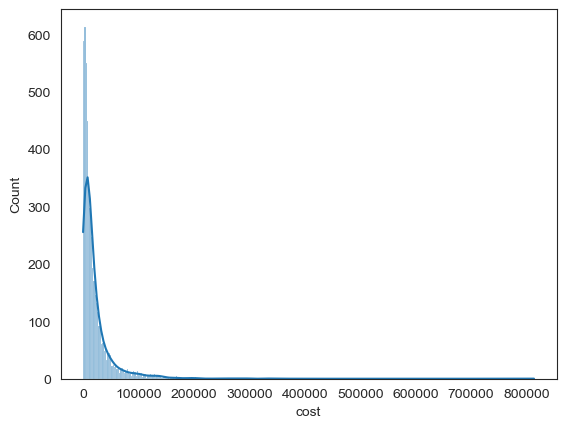

In [43]:
sns.histplot(revenue_control, kde=True)

<AxesSubplot:xlabel='cost', ylabel='Count'>

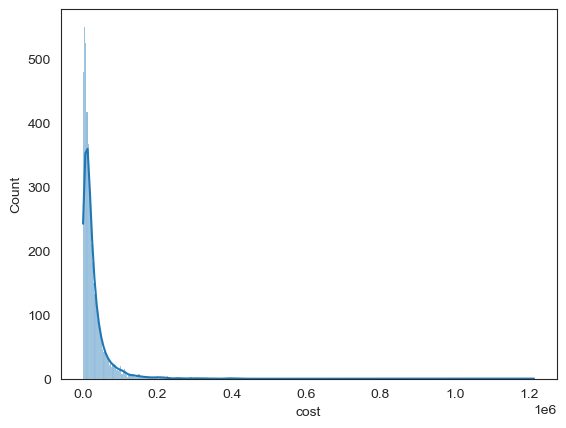

In [44]:
sns.histplot(revenue_test, kde=True)

Ненормальное распределение, используем тест Манна-Утни

In [45]:
stats.mannwhitneyu(revenue_control, revenue_test)

MannwhitneyuResult(statistic=9744125.5, pvalue=1.7353469147009308e-39)

In [46]:
revenue_for_id_group = revenue_for_id.groupby('group')['cost'].agg(['mean', 'median', 'std', 'count']).reset_index()
revenue_for_id_group

,group,mean,median,std,count
0,control,22422.119043,10997.0,39312.317621,4889
1,test,27812.309095,15498.0,41761.924948,4717


Думаю лучше взять медианное значение, так как есть товары с очень высокой ценой по сравнению с другими товарами и в среднем значении получаются большие числа. Различие между распределениями выручек статистически значимо.

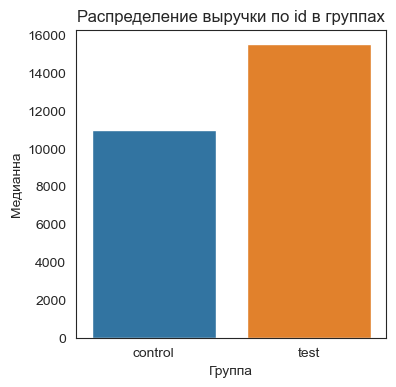

In [47]:
plt.figure(figsize = (4, 4))
sns.barplot(data = revenue_for_id_group, x = 'group', y = 'median')
plt.title('Распределение выручки по id в группах')
plt.ylabel('Медианна')
plt.xlabel('Группа')
plt.show()

Разница в выручке на клиента в контрольной и тестовой группах статистически значима

#### Число покупок на клиента 

In [49]:
purchases_for_id = df_ab.groupby(['group', 'id'])['product'].count().reset_index(name = 'num_purchases')

Среднее количество покупок на клиента в каждой группе 
      group  num_purchases
0  control       3.998364
1     test       5.230231


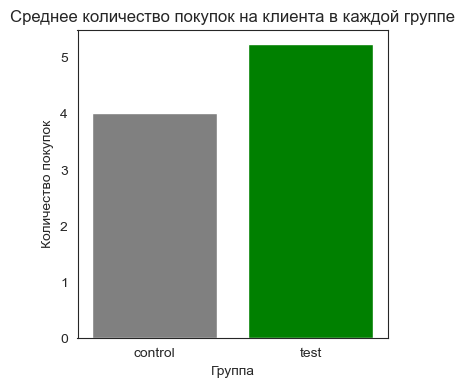

In [50]:
# Среднее число покупок на клиента в каждой группе
mean_purchases = purchases_for_id.groupby('group', as_index=False)['num_purchases'].mean()
print('Среднее количество покупок на клиента в каждой группе \n', mean_purchases)

plt.figure(figsize = (4, 4))
plt.bar(mean_purchases['group'], mean_purchases['num_purchases'], color=['gray', 'green'])
plt.title('Среднее количество покупок на клиента в каждой группе')
plt.ylabel('Количество покупок')
plt.xlabel('Группа')
plt.show()

In [51]:
purchases_control = purchases_for_id.loc[purchases_for_id['group'] == 'control', 'num_purchases']
purchases_test = purchases_for_id.loc[purchases_for_id['group'] == 'test', 'num_purchases']

<AxesSubplot:xlabel='num_purchases', ylabel='Count'>

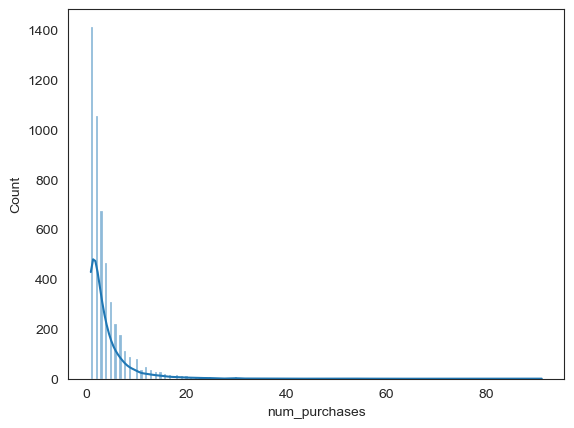

In [52]:
sns.histplot(purchases_control, kde=True)

<AxesSubplot:xlabel='num_purchases', ylabel='Count'>

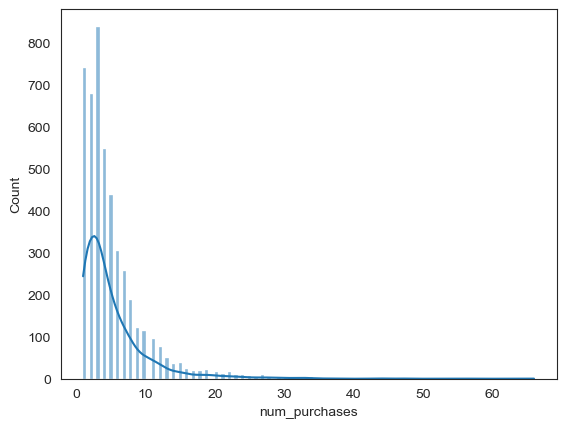

In [53]:
sns.histplot(purchases_test, kde=True)

Ненормальное распределение, используем тест Манна-Утни

In [54]:
stats.mannwhitneyu(purchases_control, purchases_test)

MannwhitneyuResult(statistic=8883462.5, pvalue=1.781841404457353e-86)

Разница в количестве покупок на клиента в контрольной и тестовой группах статистически значима

#### Количество людей с повторными покупками

In [55]:
# Добавим столбец, в котором будет отображаться кто совершил боьше одной покупки
purchases_id_dt = df_ab.groupby(['group', 'id'])['dt'].nunique().reset_index(name = 'num_purchases')
purchases_id_dt['repeat'] = purchases_id_dt["num_purchases"] > 1

Количество людей с повторными покупками 
      group  repeat
0  control    2945
1     test    3381


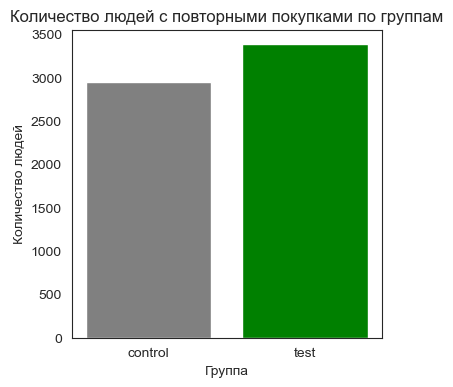

In [56]:
repeat_buyers_person = purchases_id_dt.groupby('group', as_index=False)['repeat'].sum()

print('Количество людей с повторными покупками \n', repeat_buyers_person)

plt.figure(figsize = (4, 4))
plt.bar(repeat_buyers_person['group'], repeat_buyers_person['repeat'], color=['gray', 'green'])
plt.title('Количество людей с повторными покупками по группам')
plt.ylabel('Количество людей')
plt.xlabel('Группа')
plt.show()

Так как здесь мы считаем долю клиентов, которые совершили повторную покупку, то можем использовать Z-тест

In [57]:
# Общее число людей по группам
control_total = purchases_id_dt[purchases_id_dt['group'] == 'control']['repeat'].count()
test_total = purchases_id_dt[purchases_id_dt['group'] == 'test']['repeat'].count()

# Число людей, совершивших повторную покупку
control_success = purchases_id_dt[purchases_id_dt['group'] == 'control']['repeat'].sum()
test_success = purchases_id_dt[purchases_id_dt['group'] == 'test']['repeat'].sum()

# Z- тест
successes = [control_success, test_success]
n_obs = [control_total, test_total]

Z, p = proportions_ztest(count=successes, nobs=n_obs)
print("Statistic: ",Z, ", p-value: ", p)

Statistic:  -11.820213366623557 , p-value:  3.069040598754378e-32


Различие в количестве людей совершивших повторную покупку в тестовой и контрольной группах статистически значимо.

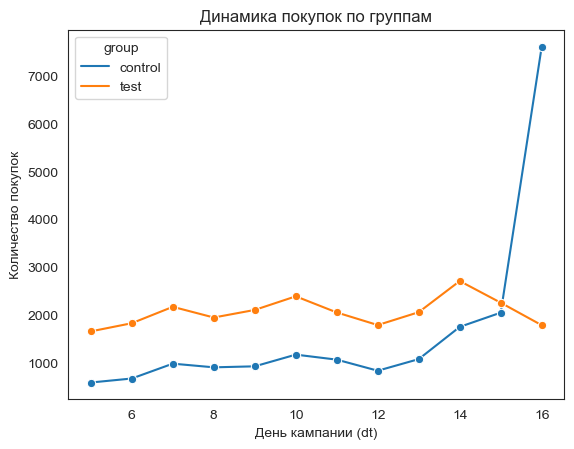

In [58]:
# Покупки по дням
purchases_by_day = df_ab.groupby(['group', 'dt'])['id'].count().reset_index(name='num_purchases')

sns.lineplot(data = purchases_by_day, x = 'dt', y = 'num_purchases', hue = 'group', marker = 'o')
plt.title('Динамика покупок по группам')
plt.ylabel('Количество покупок')
plt.xlabel('День кампании (dt)')
plt.show()

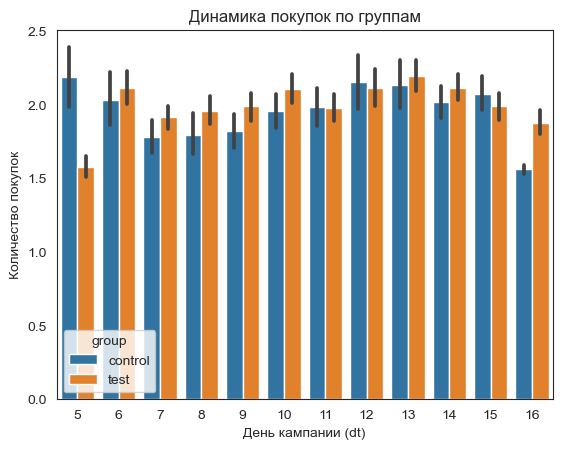

In [60]:
purchases_for_id_day = df_ab.groupby(['group', 'dt', 'id'])['product'].count().reset_index(name = 'num_purchases')

sns.barplot(data = purchases_for_id_day, x = 'dt', y = 'num_purchases', hue = 'group')
plt.title('Динамика покупок по группам')
plt.ylabel('Количество покупок')
plt.xlabel('День кампании (dt)')
plt.show()

Не смотря на наличие скидки, средний чек вырос, это означает, что люди покупают больше товаров либо переходят в более дорогой сегмент.  Число покупок и количество повторных покупок тоже больше, следовательно, акция привлекательно влияет на клиентов, провоцируя их покупать больше и возвращаться. Общая выручка выросла почти на 20% это прямое подтверждение того, что кампания эффективна.\ 

Перед тем как внедрить кампанию на всю аудиторию нужно: \
•	протестить данную кампанию на более широкую аудиторию (или другой сегмент), увеличить период и проверить стабилен ли положительный эффект; \
•	если средний чек вырос, то возможно стоит скорректировать размер скидки, сделать его меньше, тем самым снизить затраты, но сохранить заинтересованность клиентов в покупке; \
•	выделить категории покупателей, которые откликнулись на данную кампанию и запускать ее более персонализировано; \
•	обратить внимание на клиентов, которые давно не совершали покупки и на тех, кто покупает часто, но с невысоким чеком и попробовать реализовать акцию на них; \
•	перед масштабированием посчитать ROI (на данный момент это невозможно, так как не знаем затраты на рекламу). \
Общая рекомендация – продолжать и масштабировать кампанию с дальнейшей сегментацией и оптимизацией скидки.
